In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# آموزش‌های یادگیری ماشین
# فصل ۴ — مبانی یادگیری نظارت‌شده
## درس ۴: بیش‌برازش و منظم‌سازی (Ridge، LASSO، Elastic Net)

**آنچه در این درس یاد می‌گیرید**
- معنی دقیق بیش‌برازش از منظر خطای تعمیم و این‌که چرا رخ می‌دهد.
- این‌که منظم‌سازی چگونه تابع هدف یادگیری را تغییر می‌دهد و ظرفیت مدل را کنترل می‌کند.
- تفاوت‌های عملی بین **Ridge (L2)**، **LASSO (L1)** و **Elastic Net (L1+L2)**.
- روش انتخاب شدت منظم‌سازی با اعتبارسنجی و cross-validation بدون نشتی.
- ساخت پایپلاین‌های end-to-end و بدون نشتی برای داده‌های جدولی با scikit-learn.

**دیتاست‌های استفاده‌شده در این درس (انتخاب‌شده از ریپوی شما)**
- رگرسیون: `house-prices.csv` ، `diamonds.csv`
- دسته‌بندی: `diabetes.csv` ، `drug200.csv`

همه مسیرهای دیتاست در کد مطابق ساختار ریپوی شما هستند؛ برای مثال: `../../../Datasets/Regression/house-prices.csv`.

---

### جایگاه درس در فصل ۴
فصل ۴ شامل **۱۳ درس** در مورد مبانی یادگیری نظارت‌شده است. این درس روی **کنترل پیچیدگی** تمرکز دارد تا عملکرد روی داده‌های *جدید* پایدار بماند.

## فهرست مطالب
1. بیش‌برازش در برابر کم‌برازش و تعمیم
2. نگاه بایاس–واریانس (چرا پیچیدگی می‌تواند آسیب بزند)
3. منظم‌سازی به‌عنوان کمینه‌سازی ریسک تجربیِ جریمه‌دار
4. Ridge (L2): کوچک‌سازی ضرایب، پایداری و ویژگی‌های هم‌بسته
5. LASSO (L1): تنکی و انتخاب ویژگی
6. Elastic Net: ترکیب L1 و L2 برای مسائل پُربعد
7. شهود بصری: بیش‌برازش چندجمله‌ای و نقش منظم‌سازی
8. مثال عملی A (رگرسیون): House Prices — پایپلاین‌های Ridge/LASSO/Elastic Net
9. مثال عملی B (رگرسیون): Diamonds — دسته‌ها + منظم‌سازی
10. مثال عملی C (دسته‌بندی): Diabetes — رگرسیون لجستیک و منظم‌سازی
11. مثال عملی D (دسته‌بندی): Drug200 — انفجار One-Hot و منظم‌سازی
12. چک‌لیست عملی: جلوگیری از بیش‌برازش در پروژه‌های واقعی
13. (اختیاری) پیاده‌سازی Ridge از ابتدا (فقط ویژگی‌های عددی)
14. تمرین‌ها (Hands-on)
15. جمع‌بندی

In [2]:
# Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modeling tools
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, roc_auc_score

# NOTE (compatibility + deprecation fix):
# In scikit-learn >= 1.4, mean_squared_error(..., squared=False) is deprecated.
# Prefer root_mean_squared_error when available; otherwise fall back to sqrt(MSE).
try:
    from sklearn.metrics import root_mean_squared_error
except Exception:  # pragma: no cover
    def root_mean_squared_error(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, LogisticRegression

# Reproducibility
RANDOM_STATE = 42

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

## ۱) بیش‌برازش در برابر کم‌برازش و تعمیم

یک مدل **بیش‌برازش** می‌کند وقتی الگوهای *اتفاقی و مخصوص داده‌های آموزش* را یاد می‌گیرد؛ الگوهایی که در فرآیند تولید داده پایدار نیستند. این فقط «دقت آموزشی زیاد» نیست؛ بلکه وضعیتی است که:

- خطای آموزش پایین است، **اما**
- خطای اعتبارسنجی/آزمون به‌طور محسوس بالاتر است.

یک مدل **کم‌برازش** می‌کند وقتی آن‌قدر ساده و سخت‌گیر است که سیگنال اصلی را هم نمی‌تواند بگیرد؛ در نتیجه هم خطای آموزش و هم خطای آزمون بالا می‌ماند.

### چرا بیش‌برازش رخ می‌دهد؟
بیش‌برازش معمولاً با ترکیبی از عوامل زیر تشدید می‌شود:
- **ظرفیت زیاد مدل** نسبت به اندازه دیتاست (پارامترهای زیاد، فضای فرضیه پیچیده).
- **نویز در هدف** یا خطای اندازه‌گیری.
- **نشتی داده (Data Leakage)** (وجود اطلاعات هدف در ویژگی‌ها، مستقیم یا غیرمستقیم).
- **تنظیم هایپرپارامتر با نگاه به تست** (نشتی پنهان).
- **فضای ویژگی پُربعد**، مخصوصاً با one-hot encoding و دسته‌های نادر.

### خطای تعمیم
فرض کنید $\mathcal{D}$ توزیع جامعه و $\{(x_i, y_i)\}_{i=1}^n$ یک نمونه i.i.d. باشد.
الگوریتم یادگیری پارامترهای $\hat\theta$ را با کمینه‌سازی خطای آموزشی پیدا می‌کند:

$$
\hat\theta \in \arg\min_{\theta} \frac{1}{n} \sum_{i=1}^{n} \ell\big(f_{\theta}(x_i), y_i\big)
$$

**خطای تعمیم** امید ریاضیِ loss روی داده‌های جدید است:

$$
\mathcal{E}_{\text{gen}}(\hat\theta) = \mathbb{E}_{(x,y) \sim \mathcal{D}}\left[\ell\big(f_{\hat\theta}(x), y\big)\right]
$$

منظم‌سازی یکی از مستقیم‌ترین راه‌ها برای کاهش شکاف بین عملکرد آموزشی و تعمیم است.

## ۲) نگاه بایاس–واریانس (چرا پیچیدگی می‌تواند آسیب بزند)

برای رگرسیون با خطای مربعی و هدف $y = f(x) + \epsilon$ که در آن $\mathbb{E}[\epsilon]=0$ و $\mathrm{Var}(\epsilon)=\sigma^2$، امید ریاضی MSE روی تست (در یک نقطه $x$) به‌صورت مفهومی می‌تواند به شکل زیر شکسته شود:

$$
\mathbb{E}\left[(\hat f(x) - y)^2\right]
\approx \underbrace{\big(\mathbb{E}[\hat f(x)] - f(x)\big)^2}_{\text{Bias}^2}
+ \underbrace{\mathbb{E}\left[(\hat f(x) - \mathbb{E}[\hat f(x)])^2\right]}_{\text{Variance}}
+ \underbrace{\sigma^2}_{\text{Noise}}
$$

- **افزایش پیچیدگی** معمولاً بایاس را کم می‌کند اما واریانس را زیاد می‌کند.
- بیش‌برازش اغلب یک مشکل **واریانس** است: مدل با تغییر داده آموزشی خیلی تغییر می‌کند.
- منظم‌سازی معمولاً **کمی بایاس را زیاد** می‌کند اما **واریانس را کم** می‌کند و در نتیجه عملکرد تست بهتر می‌شود.

مدل ذهنی کلیدی:  
> منظم‌سازی معمولاً افزایش کوچک بایاس را با کاهش (اغلب بزرگ) واریانس معاوضه می‌کند.

## ۳) منظم‌سازی به‌عنوان کمینه‌سازی ریسک تجربیِ جریمه‌دار

منظم‌سازی تابع هدف را با اضافه کردن یک جمله جریمه تغییر می‌دهد تا راه‌حل‌های بیش‌ازحد پیچیده را محدود کند:

$$
\hat\theta \in \arg\min_{\theta}
\left[
\frac{1}{n} \sum_{i=1}^{n} \ell\big(f_{\theta}(x_i), y_i\big)
+ \lambda \; \Omega(\theta)
\right]
$$

- $\lambda \ge 0$ **شدت منظم‌سازی** را کنترل می‌کند.  
  - $\lambda$ بزرگ‌تر → راه‌حل ساده‌تر.
  - $\lambda$ کوچک‌تر → نزدیک‌تر به مدل بدون جریمه.
- $\Omega(\theta)$ **ریگولاریزر** (تابع جریمه) است.

### سه ریگولاریزر اصلی این درس
- **Ridge / L2**: $\Omega(\theta) = \lVert \theta \rVert_2^2$
- **LASSO / L1**: $\Omega(\theta) = \lVert \theta \rVert_1$
- **Elastic Net**: $\Omega(\theta) = \alpha \lVert \theta \rVert_1 + (1-\alpha)\lVert \theta \rVert_2^2$

که در آن $\alpha \in [0,1]$ (در scikit-learn با نام `l1_ratio`).

### نکته عملی بسیار مهم: مقیاس‌بندی
برای مدل‌های خطی، جریمه‌ها به اندازه ضرایب حساس‌اند؛ بنابراین **مقیاس‌بندی ویژگی‌ها ضروری است**.
در عمل: `StandardScaler` (برای عددی‌ها) + `OneHotEncoder` (برای دسته‌ای‌ها) داخل یک `Pipeline`.

## ۴) Ridge (L2): کوچک‌سازی ضرایب، پایداری و ویژگی‌های هم‌بسته

### تابع هدف Ridge regression
برای رگرسیون خطی با جریمه $\ell_2$:

$$
\hat w \in \arg\min_{w}
\left[
\frac{1}{n} \lVert Xw - y \rVert_2^2 + \lambda \lVert w \rVert_2^2
\right]
$$

### جواب بسته (وقتی ویژگی‌ها عددی‌اند و مسئله خیلی بزرگ نیست)
$$
\hat w = (X^\top X + \lambda I)^{-1} X^\top y
$$

### Ridge چه کاری انجام می‌دهد؟
- ضرایب را به سمت صفر **کوچک** می‌کند، اما معمولاً آن‌ها را دقیقاً صفر نمی‌کند.
- با **چندهمخطی** بهتر از OLS کنار می‌آید.
- وقتی $X^\top X$ نزدیک به تکین است، پایداری عددی را بهتر می‌کند.

## ۵) LASSO (L1): تنکی و انتخاب ویژگی

### تابع هدف LASSO
$$
\hat w \in \arg\min_{w}
\left[
\frac{1}{n} \lVert Xw - y \rVert_2^2 + \lambda \lVert w \rVert_1
\right]
$$

- **تنکی** ایجاد می‌کند: بسیاری از ضرایب دقیقاً **صفر** می‌شوند.
- انتخاب ویژگی را به‌صورت **Embedded** انجام می‌دهد.

### ملاحظات
- با ویژگی‌های **به‌شدت هم‌بسته**، LASSO معمولاً یکی را نگه می‌دارد و بقیه را حذف می‌کند.
- مقیاس‌بندی ویژگی‌های عددی ضروری است.

## ۶) Elastic Net: ترکیب L1 و L2

$$
\hat w \in \arg\min_{w}
\left[
\frac{1}{n} \lVert Xw - y \rVert_2^2
+ \lambda \left( \alpha \lVert w \rVert_1 + (1-\alpha) \lVert w \rVert_2^2 \right)
\right]
$$

- $\alpha=1$ → LASSO
- $\alpha=0$ → Ridge

## ۷) شهود بصری: بیش‌برازش چندجمله‌ای و نقش منظم‌سازی

ما داده را از یک تابع نرم تولید می‌کنیم و رگرسیون چندجمله‌ای با درجه‌های مختلف را برازش می‌دهیم.

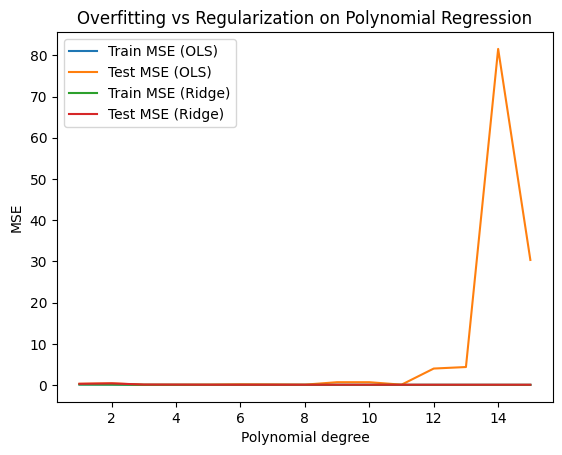

In [3]:
from sklearn.preprocessing import PolynomialFeatures

# Generate synthetic data
rng = np.random.default_rng(RANDOM_STATE)
n = 80
X = rng.uniform(-3, 3, size=(n, 1))
y_true = np.sin(X).ravel()
y = y_true + rng.normal(0, 0.25, size=n)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=RANDOM_STATE)

degrees = list(range(1, 16))
train_mse_ols, test_mse_ols = [], []
train_mse_ridge, test_mse_ridge = [], []

ridge_alpha = 1.0  # regularization strength for this toy demo

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)

    # Unregularized (OLS)
    model_ols = Pipeline([
        ("poly", poly),
        ("lr", LinearRegression())
    ])
    model_ols.fit(X_train, y_train)
    pred_tr = model_ols.predict(X_train)
    pred_te = model_ols.predict(X_test)
    train_mse_ols.append(mean_squared_error(y_train, pred_tr))
    test_mse_ols.append(mean_squared_error(y_test, pred_te))

    # Ridge on the same polynomial features (scaling helps for higher degrees)
    model_ridge = Pipeline([
        ("poly", poly),
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=ridge_alpha))
    ])
    model_ridge.fit(X_train, y_train)
    pred_tr = model_ridge.predict(X_train)
    pred_te = model_ridge.predict(X_test)
    train_mse_ridge.append(mean_squared_error(y_train, pred_tr))
    test_mse_ridge.append(mean_squared_error(y_test, pred_te))

plt.figure()
plt.plot(degrees, train_mse_ols, label="Train MSE (OLS)")
plt.plot(degrees, test_mse_ols, label="Test MSE (OLS)")
plt.plot(degrees, train_mse_ridge, label="Train MSE (Ridge)")
plt.plot(degrees, test_mse_ridge, label="Test MSE (Ridge)")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.title("Overfitting vs Regularization on Polynomial Regression")
plt.legend()
plt.show()

**چگونه نمودار را بخوانیم**
- در OLS، معمولاً MSE آموزش با افزایش درجه کاهش پیدا می‌کند.
- در OLS، MSE تست ابتدا کاهش و سپس افزایش می‌یابد (بیش‌برازش).
- Ridge معمولاً خطای آموزشی را کمی بالا می‌برد ولی برای درجات بالا می‌تواند خطای تست را کمتر کند.

## ۸) مثال عملی A (رگرسیون): House Prices — پایپلاین‌های Ridge/LASSO/Elastic Net

دیتاست: `../../../Datasets/Regression/house-prices.csv`  
هدف: `Price`

In [4]:
# Load house prices dataset
path_house = "../../../Datasets/Regression/house-prices.csv"
df_house = pd.read_csv(path_house)
df_house.head()

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


In [5]:
# Separate features and target
target = "Price"
X = df_house.drop(columns=[target])
y = df_house[target]

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_features, categorical_features

(['Home', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers'],
 ['Brick', 'Neighborhood'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

# Baseline OLS
pipe_ols = Pipeline([
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

pipe_ols.fit(X_train, y_train)
pred = pipe_ols.predict(X_test)

rmse = root_mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

rmse, mae, r2

(np.float64(10277.325457328316),
 np.float64(8338.003966571283),
 0.8276990005561011)

### RidgeCV / LassoCV / ElasticNetCV

In [7]:
alphas = np.logspace(-4, 4, 50)

pipe_ridge = Pipeline([
    ("preprocess", preprocess),
    ("model", RidgeCV(alphas=alphas, cv=5))
])

pipe_ridge.fit(X_train, y_train)
pred = pipe_ridge.predict(X_test)

rmse_ridge = root_mean_squared_error(y_test, pred)
mae_ridge = mean_absolute_error(y_test, pred)
r2_ridge = r2_score(y_test, pred)

best_alpha_ridge = pipe_ridge.named_steps["model"].alpha_

rmse_ridge, mae_ridge, r2_ridge, best_alpha_ridge

(np.float64(10246.6350647865),
 np.float64(8315.966264364932),
 0.8287265227021609,
 np.float64(1.7575106248547894))

In [8]:
# LASSO needs scaling (handled in preprocess) and often benefits from more iterations.
pipe_lasso = Pipeline([
    ("preprocess", preprocess),
    ("model", LassoCV(alphas=alphas, cv=5, max_iter=20000, random_state=RANDOM_STATE))
])

pipe_lasso.fit(X_train, y_train)
pred = pipe_lasso.predict(X_test)

rmse_lasso = root_mean_squared_error(y_test, pred)
mae_lasso = mean_absolute_error(y_test, pred)
r2_lasso = r2_score(y_test, pred)

best_alpha_lasso = pipe_lasso.named_steps["model"].alpha_

rmse_lasso, mae_lasso, r2_lasso, best_alpha_lasso

(np.float64(10314.602229887927),
 np.float64(8352.332188246926),
 0.826446831735808,
 np.float64(339.3221771895323))

In [9]:
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

pipe_enet = Pipeline([
    ("preprocess", preprocess),
    ("model", ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=20000, random_state=RANDOM_STATE))
])

pipe_enet.fit(X_train, y_train)
pred = pipe_enet.predict(X_test)

rmse_enet = root_mean_squared_error(y_test, pred)
mae_enet = mean_absolute_error(y_test, pred)
r2_enet = r2_score(y_test, pred)

best_alpha_enet = pipe_enet.named_steps["model"].alpha_
best_l1_ratio = pipe_enet.named_steps["model"].l1_ratio_

rmse_enet, mae_enet, r2_enet, best_alpha_enet, best_l1_ratio

(np.float64(10253.460418787085),
 np.float64(8323.70452683701),
 0.8284982738289953,
 np.float64(0.12648552168552957),
 np.float64(0.9))

In [10]:
results = pd.DataFrame({
    "Model": ["OLS", "Ridge", "LASSO", "ElasticNet"],
    "RMSE": [rmse, rmse_ridge, rmse_lasso, rmse_enet],
    "MAE": [mae, mae_ridge, mae_lasso, mae_enet],
    "R2": [r2, r2_ridge, r2_lasso, r2_enet],
})
results.sort_values("RMSE")

,Model,RMSE,MAE,R2
1,Ridge,10246.635065,8315.966264,0.828727
3,ElasticNet,10253.460419,8323.704527,0.828498
0,OLS,10277.325457,8338.003967,0.827699
2,LASSO,10314.602230,8352.332188,0.826447


### ضرایب و اثر کوچک‌سازی

In [11]:
# Helper to get feature names after preprocessing
ohe = pipe_enet.named_steps["preprocess"].named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

feature_names = numeric_features + list(ohe_feature_names)

def top_coefficients(pipe, top_k=15):
    coef = pipe.named_steps["model"].coef_
    s = pd.Series(coef, index=feature_names).sort_values(key=np.abs, ascending=False)
    return s.head(top_k)

top_coefficients(pipe_ridge, 12), top_coefficients(pipe_lasso, 12), top_coefficients(pipe_enet, 12)

(Neighborhood_West     12783.540134
 SqFt                  12606.249622
 Offers                -9753.236009
 Brick_No              -7988.279682
 Brick_Yes              7988.279682
 Neighborhood_East     -7341.973361
 Neighborhood_North    -5441.566773
 Bathrooms              3756.691396
 Bedrooms               3156.365612
 Home                   -247.322643
 dtype: float64,
 Neighborhood_West     1.978515e+04
 Brick_No             -1.486040e+04
 SqFt                  1.234131e+04
 Offers               -9.230231e+03
 Bathrooms             3.518110e+03
 Bedrooms              2.828537e+03
 Brick_Yes             1.186322e-11
 Home                 -0.000000e+00
 Neighborhood_East    -0.000000e+00
 Neighborhood_North   -0.000000e+00
 dtype: float64,
 Neighborhood_West     12994.790574
 SqFt                  12703.164545
 Offers                -9770.373762
 Brick_No              -8086.321699
 Brick_Yes              8083.106442
 Neighborhood_East     -7502.986655
 Neighborhood_North    -5489.1

### مسیر ضرایب Ridge (Regularization path)

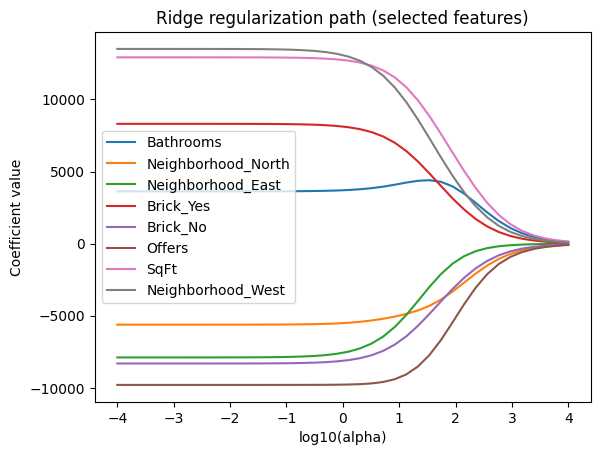

In [12]:
alphas_path = np.logspace(-4, 4, 40)
coef_path = []

for a in alphas_path:
    pipe_tmp = Pipeline([
        ("preprocess", preprocess),
        ("model", Ridge(alpha=a))
    ])
    pipe_tmp.fit(X_train, y_train)
    coef_path.append(pipe_tmp.named_steps["model"].coef_)

coef_path = np.array(coef_path)  # shape: (n_alphas, n_features_after_preprocess)

# Plot only the largest-magnitude coefficients from the best ElasticNet model for readability
enet_coefs = pipe_enet.named_steps["model"].coef_
idx = np.argsort(np.abs(enet_coefs))[-8:]  # 8 most relevant features

plt.figure()
for j in idx:
    plt.plot(np.log10(alphas_path), coef_path[:, j], label=feature_names[j])
plt.xlabel("log10(alpha)")
plt.ylabel("Coefficient value")
plt.title("Ridge regularization path (selected features)")
plt.legend()
plt.show()

## ۹) مثال عملی B (رگرسیون): Diamonds — دسته‌ها + منظم‌سازی

دیتاست: `../../../Datasets/Regression/diamonds.csv`  
هدف: `price`

In [13]:
path_diamonds = "../../../Datasets/Regression/diamonds.csv"
df_diamonds = pd.read_csv(path_diamonds)

# If dataset is very large, sample for faster experiments (still demonstrates the method).
if len(df_diamonds) > 50000:
    df_diamonds = df_diamonds.sample(50000, random_state=RANDOM_STATE)

df_diamonds.head()

,id,carat,cut,color,clarity,depth,table,price,x,y,z
1388,1389,0.24,Ideal,G,VVS1,62.1,56.0,559,3.97,4.00,2.47
50052,50053,0.58,Very Good,F,VVS2,60.0,57.0,2201,5.44,5.42,3.26
41645,41646,0.40,Ideal,E,VVS2,62.1,55.0,1238,4.76,4.74,2.95
42377,42378,0.43,Premium,E,VVS2,60.8,57.0,1304,4.92,4.89,2.98
17244,17245,1.55,Ideal,E,SI2,62.3,55.0,6901,7.44,7.37,4.61


In [14]:
target = "price"
X = df_diamonds.drop(columns=[target])
y = df_diamonds[target]

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

preprocess_d = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

pipe_ols_d = Pipeline([("preprocess", preprocess_d), ("model", LinearRegression())])
pipe_ridge_d = Pipeline([("preprocess", preprocess_d), ("model", RidgeCV(alphas=np.logspace(-3, 3, 30), cv=5))])
pipe_enet_d = Pipeline([("preprocess", preprocess_d), ("model", ElasticNetCV(
    alphas=np.logspace(-3, 3, 30),
    l1_ratio=[0.2, 0.5, 0.8],
    cv=5,
    max_iter=20000,
    random_state=RANDOM_STATE
))])

for name, pipe in [("OLS", pipe_ols_d), ("RidgeCV", pipe_ridge_d), ("ElasticNetCV", pipe_enet_d)]:
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    rmse = root_mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(name, "RMSE:", round(float(rmse), 2), "R2:", round(float(r2), 3))

print("Best Ridge alpha:", pipe_ridge_d.named_steps["model"].alpha_)
print("Best ElasticNet alpha:", pipe_enet_d.named_steps["model"].alpha_, "l1_ratio:", pipe_enet_d.named_steps["model"].l1_ratio_)

OLS RMSE: 1112.05 R2: 0.922
RidgeCV RMSE: 1111.53 R2: 0.922
ElasticNetCV RMSE: 1111.94 R2: 0.922
Best Ridge alpha: 22.122162910704503
Best ElasticNet alpha: 0.0041753189365604 l1_ratio: 0.8


## ۱۰) مثال عملی C (دسته‌بندی): Diabetes — رگرسیون لجستیک و منظم‌سازی

دیتاست: `../../../Datasets/Classification/diabetes.csv`  
هدف: `classification`

In [15]:
path_diabetes = "../../../Datasets/Classification/diabetes.csv"
df_diabetes = pd.read_csv(path_diabetes)
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


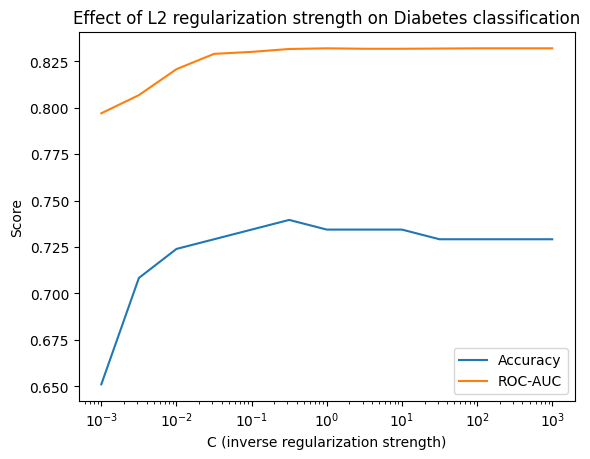

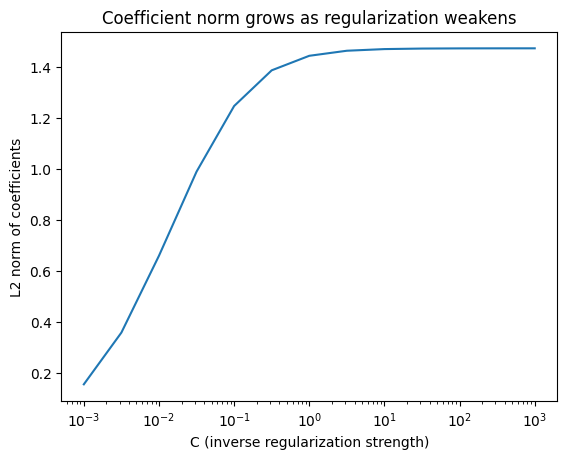

In [16]:
# Basic preprocessing: all numeric features here (based on the dataset header you provided)
target = "classification"
X = df_diabetes.drop(columns=[target])

# Robust binary label conversion:
# IMPORTANT FIX: do NOT use ".contains('diabetic')" because it marks "non-diabetic" as diabetic too.
y_str = df_diabetes[target].astype(str).str.strip().str.lower()

mapping = {
    "diabetic": 1,
    "non-diabetic": 0,
    "yes": 1, "no": 0,
    "true": 1, "false": 0,
    "1": 1, "0": 0
}
y_bin = y_str.map(mapping)

# Fallback if there are unexpected labels
if y_bin.isna().any():
    y_bin = (y_str.str.contains("diab") & ~y_str.str.contains("non")).astype(int)

y_bin = y_bin.astype(int)

# Safety check
if y_bin.nunique() < 2:
    raise ValueError(
        "Binary label encoding produced only one class. "
        "Please check the 'classification' column values in diabetes.csv."
    )

X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.25, random_state=RANDOM_STATE, stratify=y_bin
)

# Compare several C values for L2-regularized logistic regression
Cs = np.logspace(-3, 3, 13)
accs, aucs, coef_norms = [], [], []

for C in Cs:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(C=C, penalty="l2", solver="lbfgs", max_iter=5000))
    ])
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)
    accs.append(accuracy_score(y_test, pred))
    aucs.append(roc_auc_score(y_test, proba))
    coef = pipe.named_steps["clf"].coef_.ravel()
    coef_norms.append(np.linalg.norm(coef, ord=2))

plt.figure()
plt.semilogx(Cs, accs, label="Accuracy")
plt.semilogx(Cs, aucs, label="ROC-AUC")
plt.xlabel("C (inverse regularization strength)")
plt.ylabel("Score")
plt.title("Effect of L2 regularization strength on Diabetes classification")
plt.legend()
plt.show()

plt.figure()
plt.semilogx(Cs, coef_norms)
plt.xlabel("C (inverse regularization strength)")
plt.ylabel("L2 norm of coefficients")
plt.title("Coefficient norm grows as regularization weakens")
plt.show()

در ادامه، L1 را با L2 مقایسه می‌کنیم. برای L1 در scikit-learn معمولاً `solver="saga"` استفاده می‌شود.

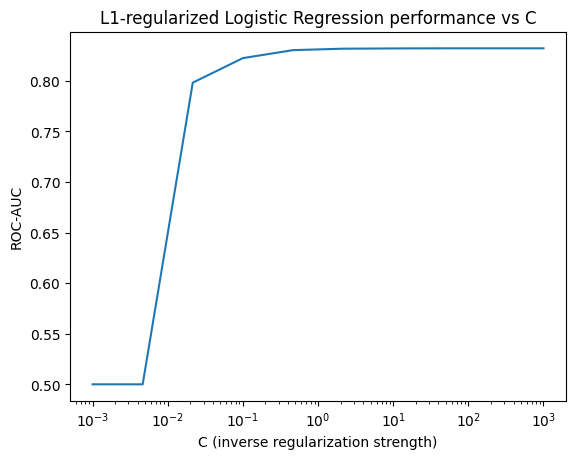

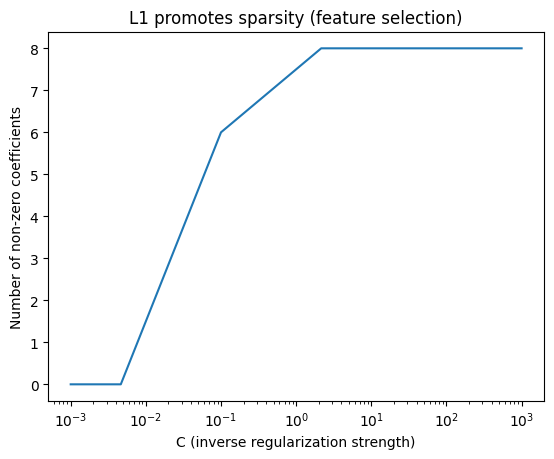

In [17]:
Cs = np.logspace(-3, 3, 10)
nonzero_counts = []
test_scores = []

for C in Cs:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(C=C, penalty="l1", solver="saga", max_iter=8000))
    ])
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, proba)
    test_scores.append(auc)
    coef = pipe.named_steps["clf"].coef_.ravel()
    nonzero_counts.append(np.sum(np.abs(coef) > 1e-8))

plt.figure()
plt.semilogx(Cs, test_scores)
plt.xlabel("C (inverse regularization strength)")
plt.ylabel("ROC-AUC")
plt.title("L1-regularized Logistic Regression performance vs C")
plt.show()

plt.figure()
plt.semilogx(Cs, nonzero_counts)
plt.xlabel("C (inverse regularization strength)")
plt.ylabel("Number of non-zero coefficients")
plt.title("L1 promotes sparsity (feature selection)")
plt.show()

## ۱۱) مثال عملی D (دسته‌بندی): Drug200 — انفجار One-Hot و منظم‌سازی

In [18]:
path_drug = "../../../Datasets/Classification/drug200.csv"
df_drug = pd.read_csv(path_drug)
df_drug.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


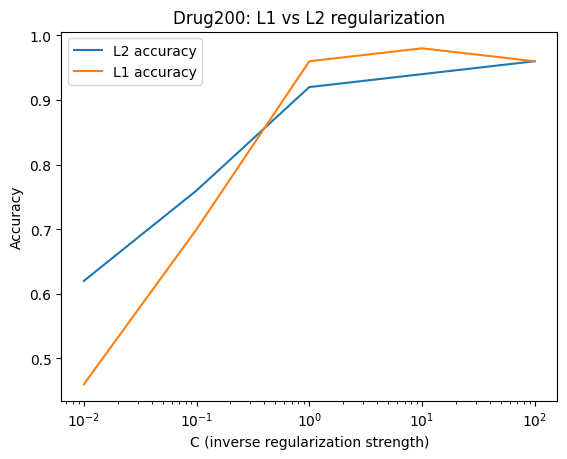

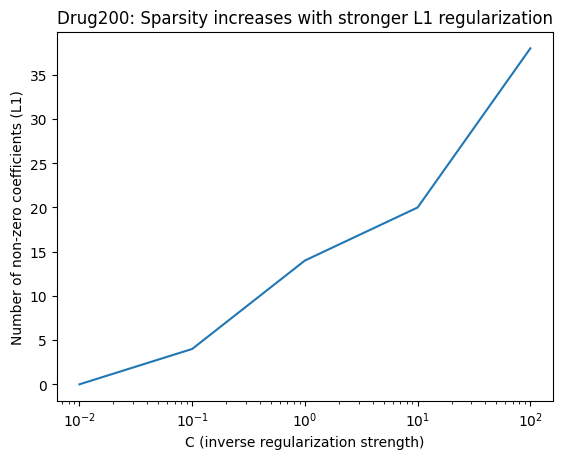

In [19]:
target = "Drug"
X = df_drug.drop(columns=[target])
y = df_drug[target].astype(str)

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

preprocess_drug = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

def fit_eval_logreg(penalty, C):
    # 'saga' supports multinomial + l1/l2
    pipe = Pipeline([
        ("preprocess", preprocess_drug),
        ("clf", LogisticRegression(
            penalty=penalty,
            C=C,
            solver="saga",
            max_iter=8000,
        ))
    ])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, pred)
    return pipe, acc

Cs = [0.01, 0.1, 1, 10, 100]
acc_l2, acc_l1, nz_l1 = [], [], []

for C in Cs:
    _, a2 = fit_eval_logreg("l2", C)
    pipe_l1, a1 = fit_eval_logreg("l1", C)
    acc_l2.append(a2)
    acc_l1.append(a1)

    # Count non-zero coefficients for L1 model (sparsity)
    coef = pipe_l1.named_steps["clf"].coef_
    nz_l1.append(np.sum(np.abs(coef) > 1e-8))

plt.figure()
plt.semilogx(Cs, acc_l2, label="L2 accuracy")
plt.semilogx(Cs, acc_l1, label="L1 accuracy")
plt.xlabel("C (inverse regularization strength)")
plt.ylabel("Accuracy")
plt.title("Drug200: L1 vs L2 regularization")
plt.legend()
plt.show()

plt.figure()
plt.semilogx(Cs, nz_l1)
plt.xlabel("C (inverse regularization strength)")
plt.ylabel("Number of non-zero coefficients (L1)")
plt.title("Drug200: Sparsity increases with stronger L1 regularization")
plt.show()

## ۱۲) چک‌لیست عملی: جلوگیری از بیش‌برازش (و استفاده صحیح از منظم‌سازی)

- یک **مجموعه تست واقعی** را تا پایان دست‌نخورده نگه دارید.
- همه preprocessing را داخل پایپلاین انجام دهید.
- هایپرپارامترها را با cross-validation روی train انتخاب کنید.
- مقیاس‌بندی را برای مدل‌های منظم‌سازی‌شده همیشه رعایت کنید.
- کنترل نشتی داده را جدی بگیرید.

## ۱۳) (اختیاری) پیاده‌سازی Ridge از ابتدا (فقط ویژگی‌های عددی)

برای این بخش از دیتاست `cognitive.csv` استفاده می‌کنیم.

In [20]:
path_cog = "../../../Datasets/Regression/cognitive.csv"
df_cog = pd.read_csv(path_cog)
df_cog.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,yes,121.117529,yes,27
1,98,yes,89.361882,yes,25
2,85,yes,115.443165,yes,27
3,83,yes,99.449639,yes,25
4,115,yes,92.745710,yes,27


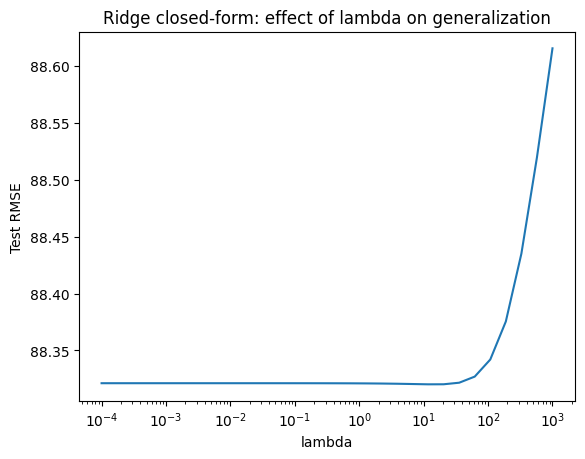

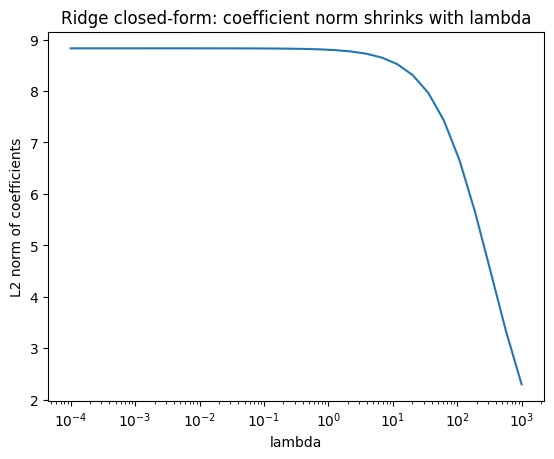

In [21]:
# Predict kid_score using numeric-coded features
# We'll convert yes/no to 1/0 for simplicity (still numeric).
df = df_cog.copy()
for col in ["mom_hs", "mom_work"]:
    df[col] = (df[col].astype(str).str.lower() == "yes").astype(int)

X = df.drop(columns=["kid_score"]).to_numpy(dtype=float)
y = df["kid_score"].to_numpy(dtype=float)

# Train/test split
idx = np.arange(len(df))
rng = np.random.default_rng(RANDOM_STATE)
rng.shuffle(idx)
split = int(0.75 * len(idx))
tr_idx, te_idx = idx[:split], idx[split:]

X_train, X_test = X[tr_idx], X[te_idx]
y_train, y_test = y[tr_idx], y[te_idx]

# Standardize numeric features (important for ridge)
mu = X_train.mean(axis=0)
sd = X_train.std(axis=0) + 1e-12
X_train_s = (X_train - mu) / sd
X_test_s = (X_test - mu) / sd

def ridge_closed_form(X, y, lam):
    # X: (n, d), y: (n,)
    n, d = X.shape
    A = X.T @ X + lam * np.eye(d)
    b = X.T @ y
    w = np.linalg.solve(A, b)
    return w

lams = np.logspace(-4, 3, 30)
test_rmse = []
coef_norm = []

for lam in lams:
    w = ridge_closed_form(X_train_s, y_train, lam)
    pred = X_test_s @ w
    test_rmse.append(root_mean_squared_error(y_test, pred))
    coef_norm.append(np.linalg.norm(w))

plt.figure()
plt.semilogx(lams, test_rmse)
plt.xlabel("lambda")
plt.ylabel("Test RMSE")
plt.title("Ridge closed-form: effect of lambda on generalization")
plt.show()

plt.figure()
plt.semilogx(lams, coef_norm)
plt.xlabel("lambda")
plt.ylabel("L2 norm of coefficients")
plt.title("Ridge closed-form: coefficient norm shrinks with lambda")
plt.show()

## ۱۴) تمرین‌ها
- تمرین ۱: Ridge/LASSO/Elastic Net را با split جدید اجرا کنید و RMSE و R2 را مقایسه کنید.
- تمرین ۲: مسیر LASSO را رسم کنید و ویژگی‌های باقی‌مانده را تحلیل کنید.
- تمرین ۳: Nested CV بسازید (CV داخلی برای انتخاب هایپرپارامتر، CV بیرونی برای برآورد عملکرد).
- تمرین ۴: Drug200 — تعداد ویژگی‌های one-hot و تعداد ضرایب غیرصفر L1 را بررسی کنید.

## ۱۵) جمع‌بندی
- بیش‌برازش اغلب ناشی از واریانس بالا است.
- Ridge (L2): پایدار و انتخاب پیش‌فرض خوب برای ویژگی‌های هم‌بسته.
- LASSO (L1): تنکی و انتخاب ویژگی، اما حساس به هم‌بستگی.
- Elastic Net: مصالحه خوب برای فضای پُربعد/one-hot.